In [1]:
!pip uninstall mediapipe -y
!pip install mediapipe==0.10.10 --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 70.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.0 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


In [2]:
import os
import cv2
import numpy as np
import mediapipe as mp

# Constants
VIDEO_FILE = '/content/drive/MyDrive/hr_ds/subject3/vid.avi'
GT_FILE = '/content/drive/MyDrive/hr_ds/subject3/ground_truth.txt'
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELS = 3  # Assuming RGB color images

# Function to check file existence=
def check_file_exist(path: str):
    if not os.path.exists(path):
        raise Exception(f'Cannot find path: "{path}"')

# Function to load video frames
def load_video_frames(path: str) -> list:
    check_file_exist(path)
    video = cv2.VideoCapture(path)
    frames = []
    ret, frame = video.read()
    while ret:
        frames.append(frame)
        ret, frame = video.read()
    video.release()
    return frames

# Function to process the video and extract faces using Mediapipe
def process_video_mediapipe(video_path: str):
    print(f"Processing video: {video_path}")

    cropped_faces = []
    frames = load_video_frames(video_path)

    mp_face_detection = mp.solutions.face_detection

    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        for frame in frames:
            results = face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            if results.detections:
                for detection in results.detections:
                    bboxC = detection.location_data.relative_bounding_box
                    ih, iw, _ = frame.shape
                    x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
                    face = frame[y:y+h, x:x+w]
                    cropped_faces.append(face)

    return cropped_faces

# Process video and extract faces
frames = load_video_frames(VIDEO_FILE)
cropped_faces = process_video_mediapipe(VIDEO_FILE)
print(f"Loaded {len(frames)} frames and extracted {len(cropped_faces)} faces.")

# Preprocess images
def preprocess_images(images):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        processed_images.append(img_resized)
    return np.array(processed_images)

preprocessed_faces = preprocess_images(cropped_faces)
print(f"Preprocessed {len(preprocessed_faces)} faces.")


Processing video: /content/drive/MyDrive/hr_ds/subject3/vid.avi
Loaded 1801 frames and extracted 1801 faces.
Preprocessed 1801 faces.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


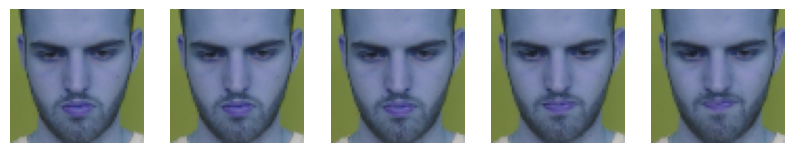

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Normalize and prepare data
X = np.array(preprocessed_faces).astype('float32') / 255.0

# Read ground truth values
gt_values = []
try:
    with open(GT_FILE, 'r') as file:
        gt_values = file.readline().strip().split()
        gt_values = list(map(float, gt_values))
except Exception as e:
    print(f"Failed to read ground truth values: {e}")

# Ensure ground truth values match frames
if len(gt_values) != len(cropped_faces):
    raise Exception("Mismatch between ground truth values and number of cropped faces.")

# Convert to numpy array
Y = np.array(gt_values).reshape(-1, 1)

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Show sample extracted faces
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(preprocessed_faces[i])
    plt.axis('off')
plt.show()


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

def lenet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    x = Conv2D(6, (5, 5), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(16, (5, 5), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(120, activation='relu')(x)
    x = Dense(84, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)
    return Model(inputs, outputs)

# Train LeNet model
lenet = lenet_model()
lenet.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='mse', metrics=['mae'])
lenet.fit(X_train, Y_train, epochs=15, batch_size=32, validation_split=0.2)
lenet.save('lenet_hr_model.keras')


Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - loss: 1.0572 - mae: 0.8042 - val_loss: 1.0060 - val_mae: 0.7823
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - loss: 1.0323 - mae: 0.8037 - val_loss: 1.0004 - val_mae: 0.7797
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 0.9834 - mae: 0.7861 - val_loss: 1.0092 - val_mae: 0.7840
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - loss: 1.1411 - mae: 0.8550 - val_loss: 1.0031 - val_mae: 0.7801
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - loss: 1.0051 - mae: 0.7767 - val_loss: 0.9992 - val_mae: 0.7780
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - loss: 1.0224 - mae: 0.8093 - val_loss: 1.0082 - val_mae: 0.7828
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - loss: 1.0103 - mae: 0.7936 - val_loss: 1.0105 - val_mae: 0.7844
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - loss: 1.0776 - mae: 0.8302 - val_loss: 0.9959 - val_mae: 0.7759
Epoch 9/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - 

In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate model on test set
test_loss, test_mae = lenet.evaluate(X_test, Y_test)

# Predict on test set
Y_pred = lenet.predict(X_test)

# Compute MSE
mse = mean_squared_error(Y_test, Y_pred)

# Compute RMSE
rmse = np.sqrt(mse)

# Compute MAE
mae = mean_absolute_error(Y_test, Y_pred)

# Print results
print(f"Test Loss (MSE from model): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.0029 - mae: 0.7989
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Test Loss (MSE from model): 1.0694
Test MAE: 0.8239
Mean Squared Error (MSE): 1.0694
Root Mean Squared Error (RMSE): 1.0341
Mean Absolute Error (MAE): 0.8239


In [6]:
pip install graphviz pydot


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │       376,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,168,685 (4.46 MB)

 Trainable params: 389,561 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 779,124 (2.97 MB)

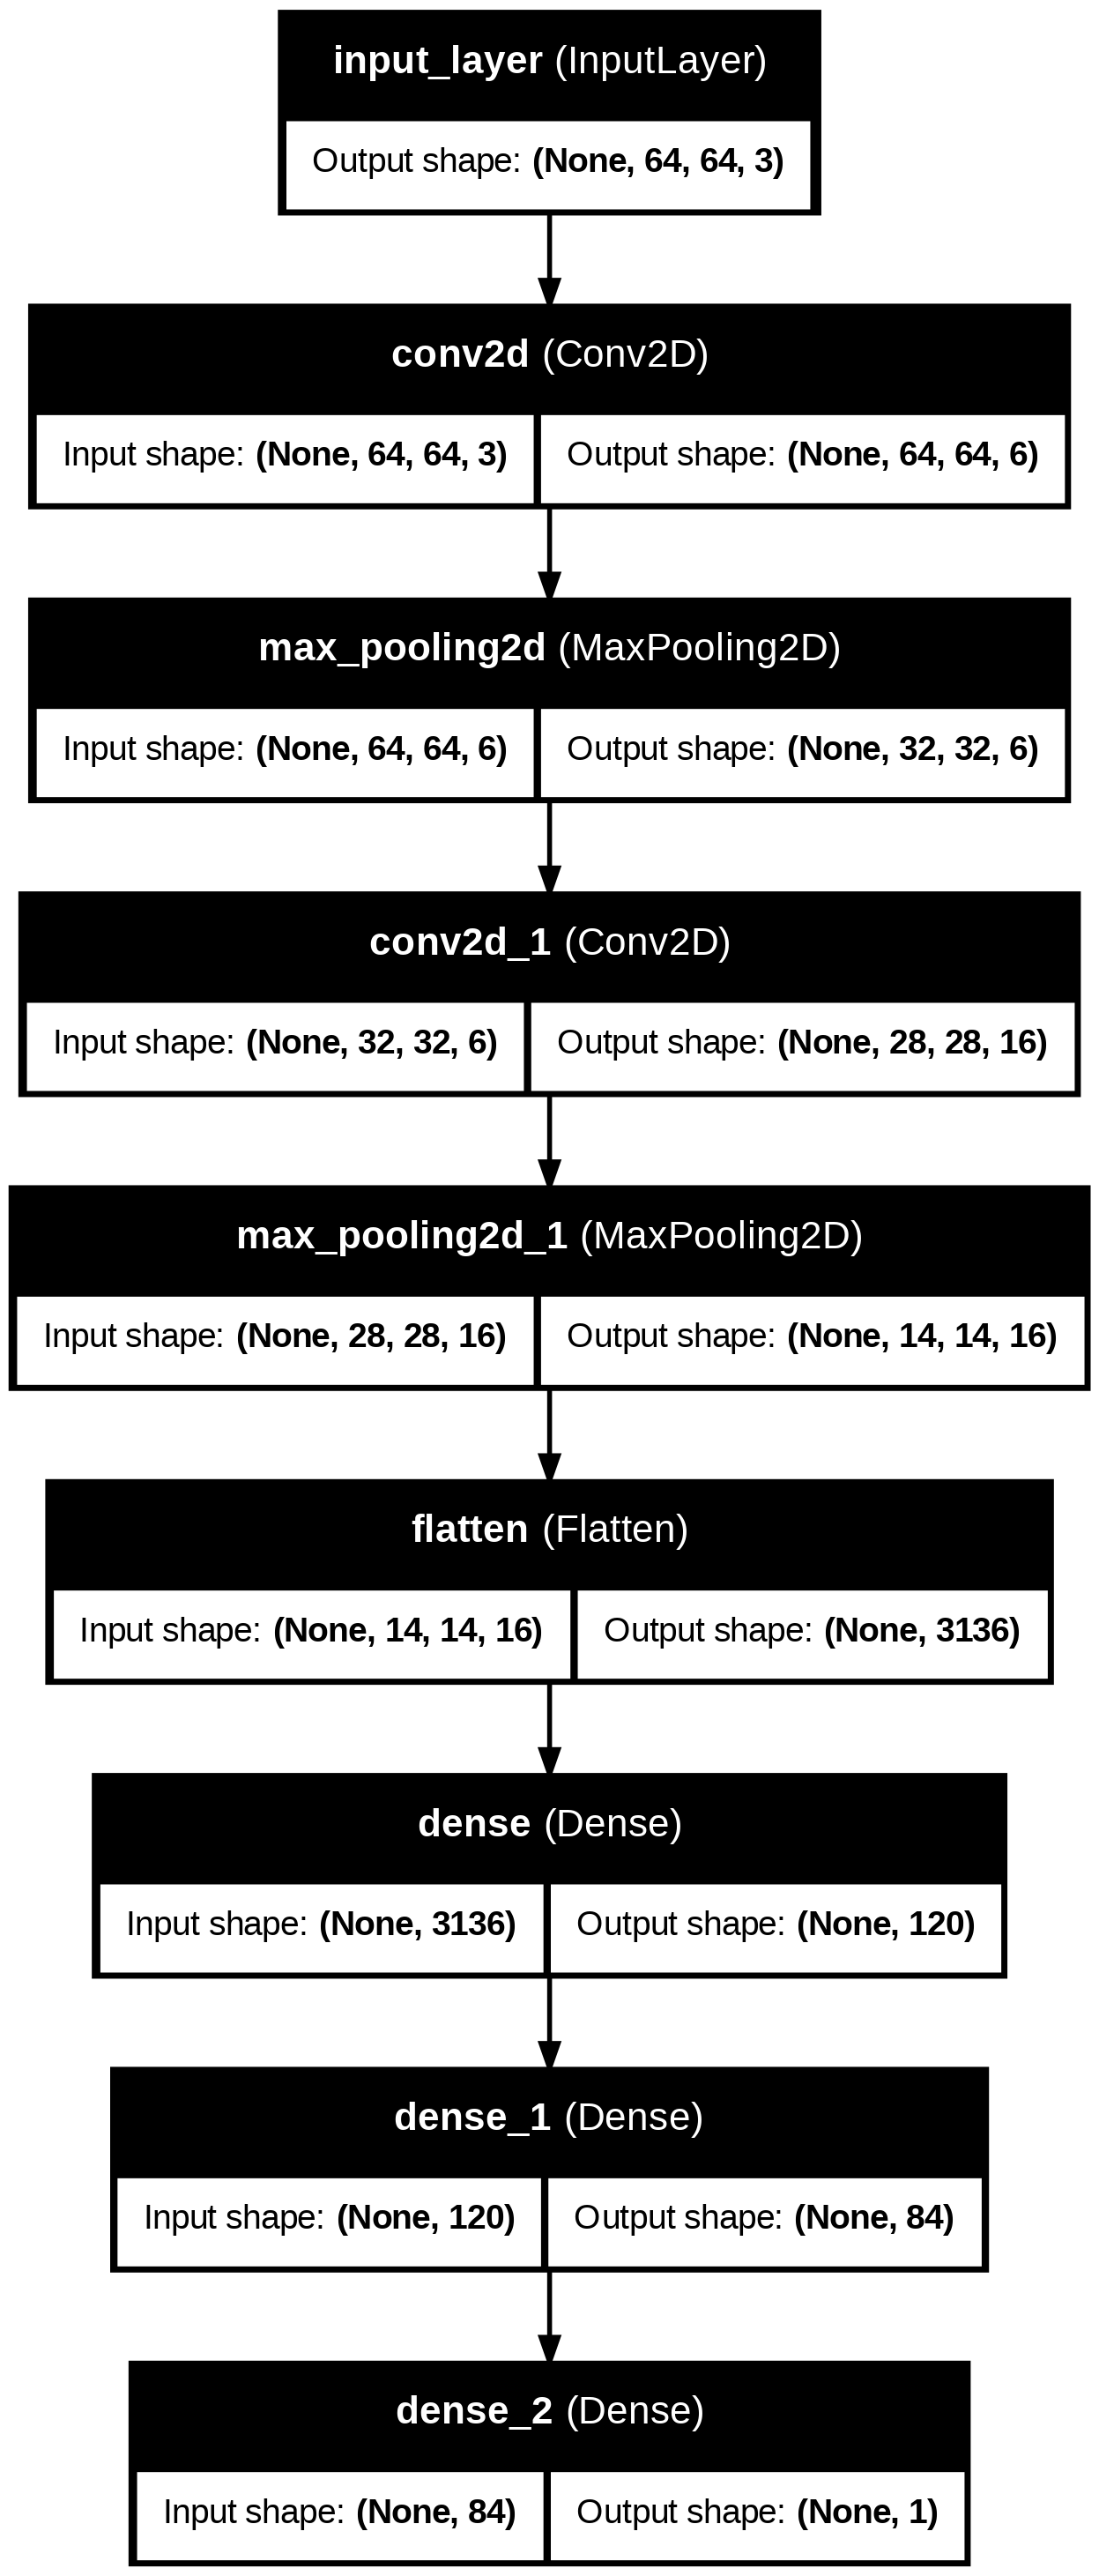

In [7]:
from tensorflow.keras.utils import plot_model

# Print model summary
lenet.summary()

# Save and display model architecture
plot_model(lenet, to_file='lenet_model.png', show_shapes=True, show_layer_names=True)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout

def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    return model

cnn = create_cnn_model()
cnn.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='mse', metrics=['mae'])
cnn.fit(X_train, Y_train, epochs=15, batch_size=32, validation_split=0.2)
cnn.save('cnn_hr_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 394ms/step - loss: 4.4904 - mae: 1.6558 - val_loss: 1.0056 - val_mae: 0.7844
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 385ms/step - loss: 1.2054 - mae: 0.8864 - val_loss: 1.0155 - val_mae: 0.7895
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - loss: 1.1226 - mae: 0.8587 - val_loss: 1.0212 - val_mae: 0.7924
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - loss: 1.1012 - mae: 0.8441 - val_loss: 1.0230 - val_mae: 0.7929
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 376ms/step - loss: 0.9887 - mae: 0.7801 - val_loss: 1.0267 - val_mae: 0.7939
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 397ms/step - loss: 1.0255 - mae: 0.7954 - val_loss: 1.0310 - val_mae: 0.7947
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 379ms/step - loss: 1.0009 - mae: 0.7801 - val_loss: 1.0319 - val_mae: 0.7941
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 395ms/step - loss: 1.0085 - mae: 0.7866 - val_loss: 1.0330 - val_mae: 0.7927
Epoch 9/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 380ms/

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate model on test set
test_loss, test_mae = cnn.evaluate(X_test, Y_test)

# Predict on test set
Y_pred = cnn.predict(X_test)

# Compute MSE
mse = mean_squared_error(Y_test, Y_pred)

# Compute RMSE
rmse = np.sqrt(mse)

# Compute MAE
mae = mean_absolute_error(Y_test, Y_pred)

# Print results
print(f"Test Loss (MSE from model): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.9929 - mae: 0.7858
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Test Loss (MSE from model): 1.0660
Test MAE: 0.8130
Mean Squared Error (MSE): 1.0660
Root Mean Squared Error (RMSE): 1.0325
Mean Absolute Error (MAE): 0.8130


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,920,325 (14.95 MB)

 Trainable params: 1,306,625 (4.98 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2,613,252 (9.97 MB)

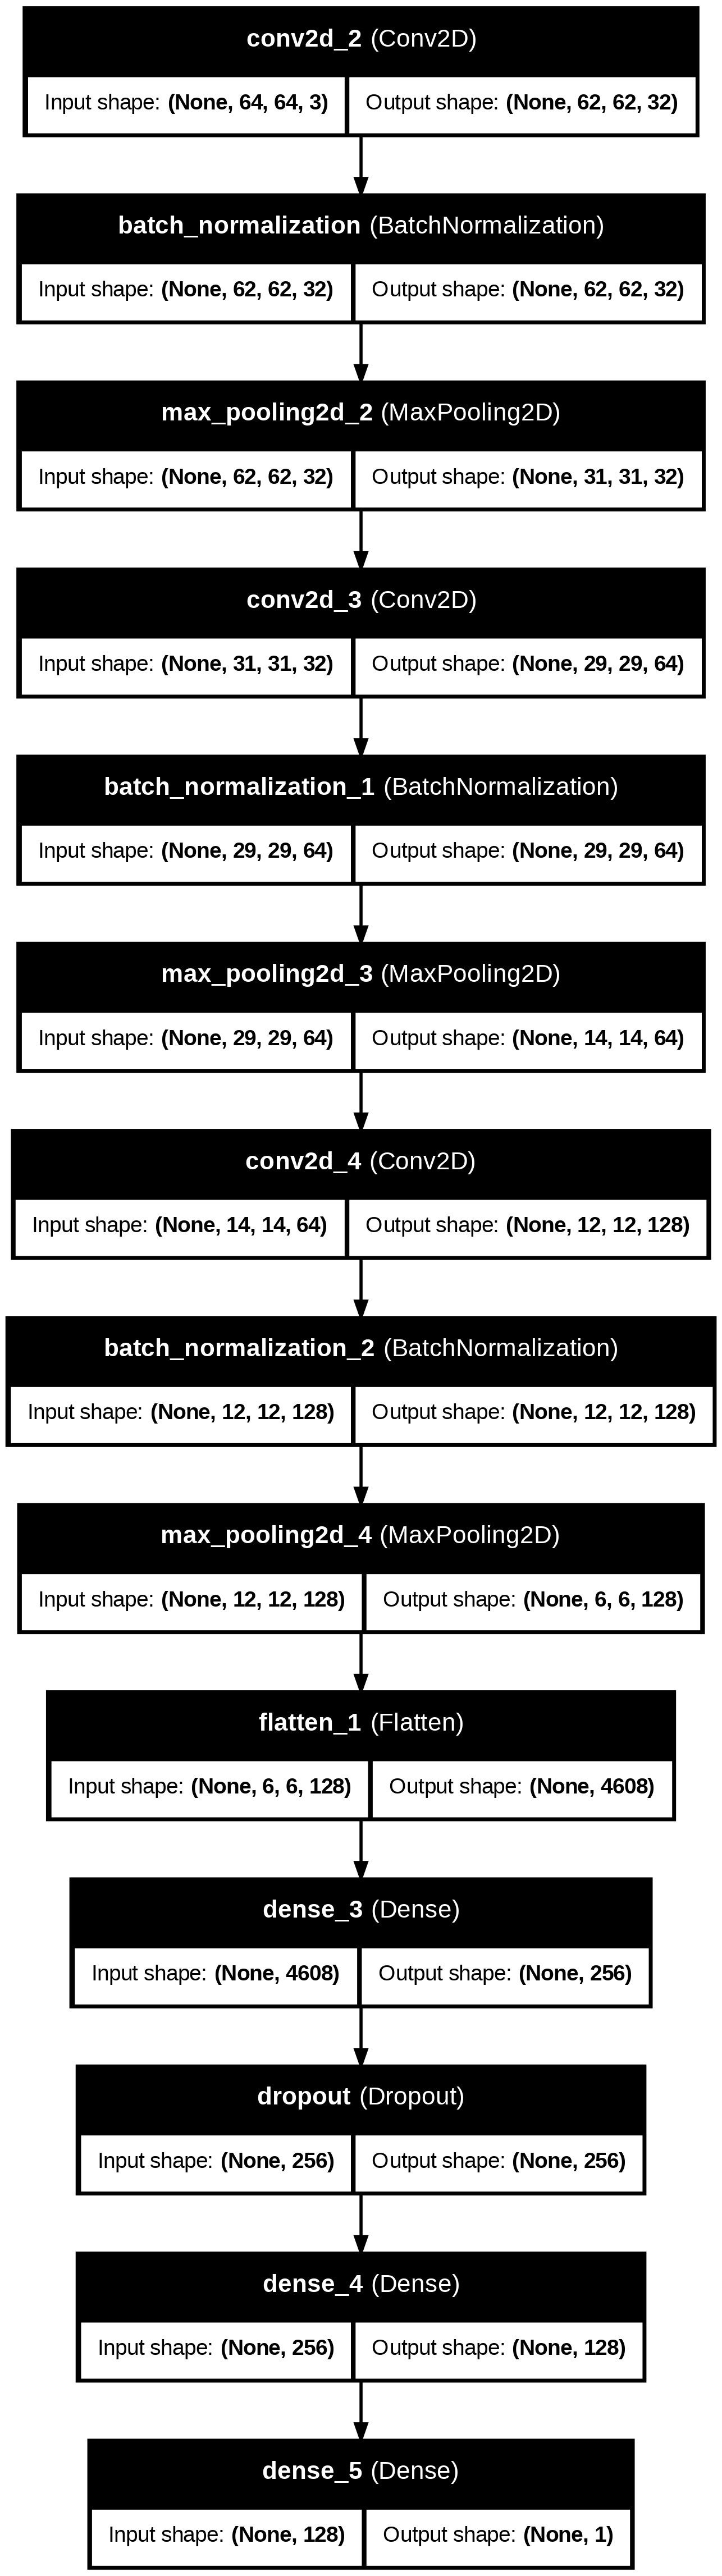

In [10]:
from tensorflow.keras.utils import plot_model

# Print model summary
cnn.summary()

# Save and display model architecture
plot_model(cnn, to_file='lenet_model.png', show_shapes=True, show_layer_names=True)


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Input, Dropout, concatenate
from tensorflow.keras.models import Model

def inception_module(x, filters):
    f1, f2_reduce, f2, f3_reduce, f3, f4 = filters

    # 1x1 Convolution
    conv1x1_1 = Conv2D(f1, (1, 1), activation='relu', padding='same')(x)

    # 1x1 Convolution -> 3x3 Convolution
    conv1x1_2 = Conv2D(f2_reduce, (1, 1), activation='relu', padding='same')(x)
    conv3x3 = Conv2D(f2, (3, 3), activation='relu', padding='same')(conv1x1_2)

    # 1x1 Convolution -> 5x5 Convolution
    conv1x1_3 = Conv2D(f3_reduce, (1, 1), activation='relu', padding='same')(x)
    conv5x5 = Conv2D(f3, (5, 5), activation='relu', padding='same')(conv1x1_3)

    # 3x3 MaxPooling -> 1x1 Convolution
    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_4 = Conv2D(f4, (1, 1), activation='relu', padding='same')(maxpool)

    # Concatenate all branches
    output = concatenate([conv1x1_1, conv3x3, conv5x5, conv1x1_4], axis=-1)

    return output

def googlenet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(shape=input_shape)

    # Initial Convolution and Pooling
    x = Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # First Inception Block
    x = inception_module(x, [64, 96, 128, 16, 32, 32])

    # Second Inception Block
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Third Inception Block
    x = inception_module(x, [192, 96, 208, 16, 48, 64])

    # Fourth Inception Block
    x = inception_module(x, [160, 112, 224, 24, 64, 64])

    # Fifth Inception Block
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='linear')(x)

    return Model(inputs, outputs)

# Instantiate and compile GoogLeNet
googlenet = googlenet_model()
googlenet.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='mse', metrics=['mae'])

# Train the model
googlenet.fit(X_train, Y_train, epochs=15, batch_size=32, validation_split=0.2)

# Save the model
googlenet.save('googlenet_hr_model.keras')


Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - loss: 1.0188 - mae: 0.7906 - val_loss: 1.0106 - val_mae: 0.7856
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 1.0686 - mae: 0.8283 - val_loss: 1.0016 - val_mae: 0.7809
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 0.9959 - mae: 0.7858 - val_loss: 1.0044 - val_mae: 0.7817
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 1.0020 - mae: 0.7779 - val_loss: 1.0039 - val_mae: 0.7816
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - loss: 1.1014 - mae: 0.8327 - val_loss: 1.0021 - val_mae: 0.7807
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 1.0500 - mae: 0.8155 - val_loss: 1.0021 - val_mae: 0.7807
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - loss: 1.0425 - mae: 0.8143 - val_loss: 1.0026 - val_mae: 0.7809
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 1.0753 - mae: 0.8184 - val_loss: 1.0024 - val_mae: 0.7807
Epoch 9/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 1.1048 - mae: 

In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate model on test set
test_loss, test_mae = googlenet.evaluate(X_test, Y_test)

# Predict on test set
Y_pred = googlenet.predict(X_test)

# Compute MSE
mse = mean_squared_error(Y_test, Y_pred)

# Compute RMSE
rmse = np.sqrt(mse)

# Compute MAE
mae = mean_absolute_error(Y_test, Y_pred)

# Print results
print(f"Test Loss (MSE from model): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - loss: 1.0115 - mae: 0.8053
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 481ms/step
Test Loss (MSE from model): 1.0750
Test MAE: 0.8299
Mean Squared Error (MSE): 1.0750
Root Mean Squared Error (RMSE): 1.0368
Mean Absolute Error (MAE): 0.8299


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      9,472 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │      6,240 │ max_pooling2d_5[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │      1,040 │ max_pooling2d_5[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ max_pooling2d_5[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │      4,160 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │    110,720 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │     12,832 │ conv2d_9[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │      2,080 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_6[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_8[0][0],   │
│                     │                   │            │ conv2d_10[0][0],  │
│                     │                   │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │    221,376 │ conv2d_13[0][0]   │
│                     │ 192)              │            │                 

 Total params: 30,784,133 (117.43 MB)

 Trainable params: 10,261,377 (39.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,522,756 (78.29 MB)

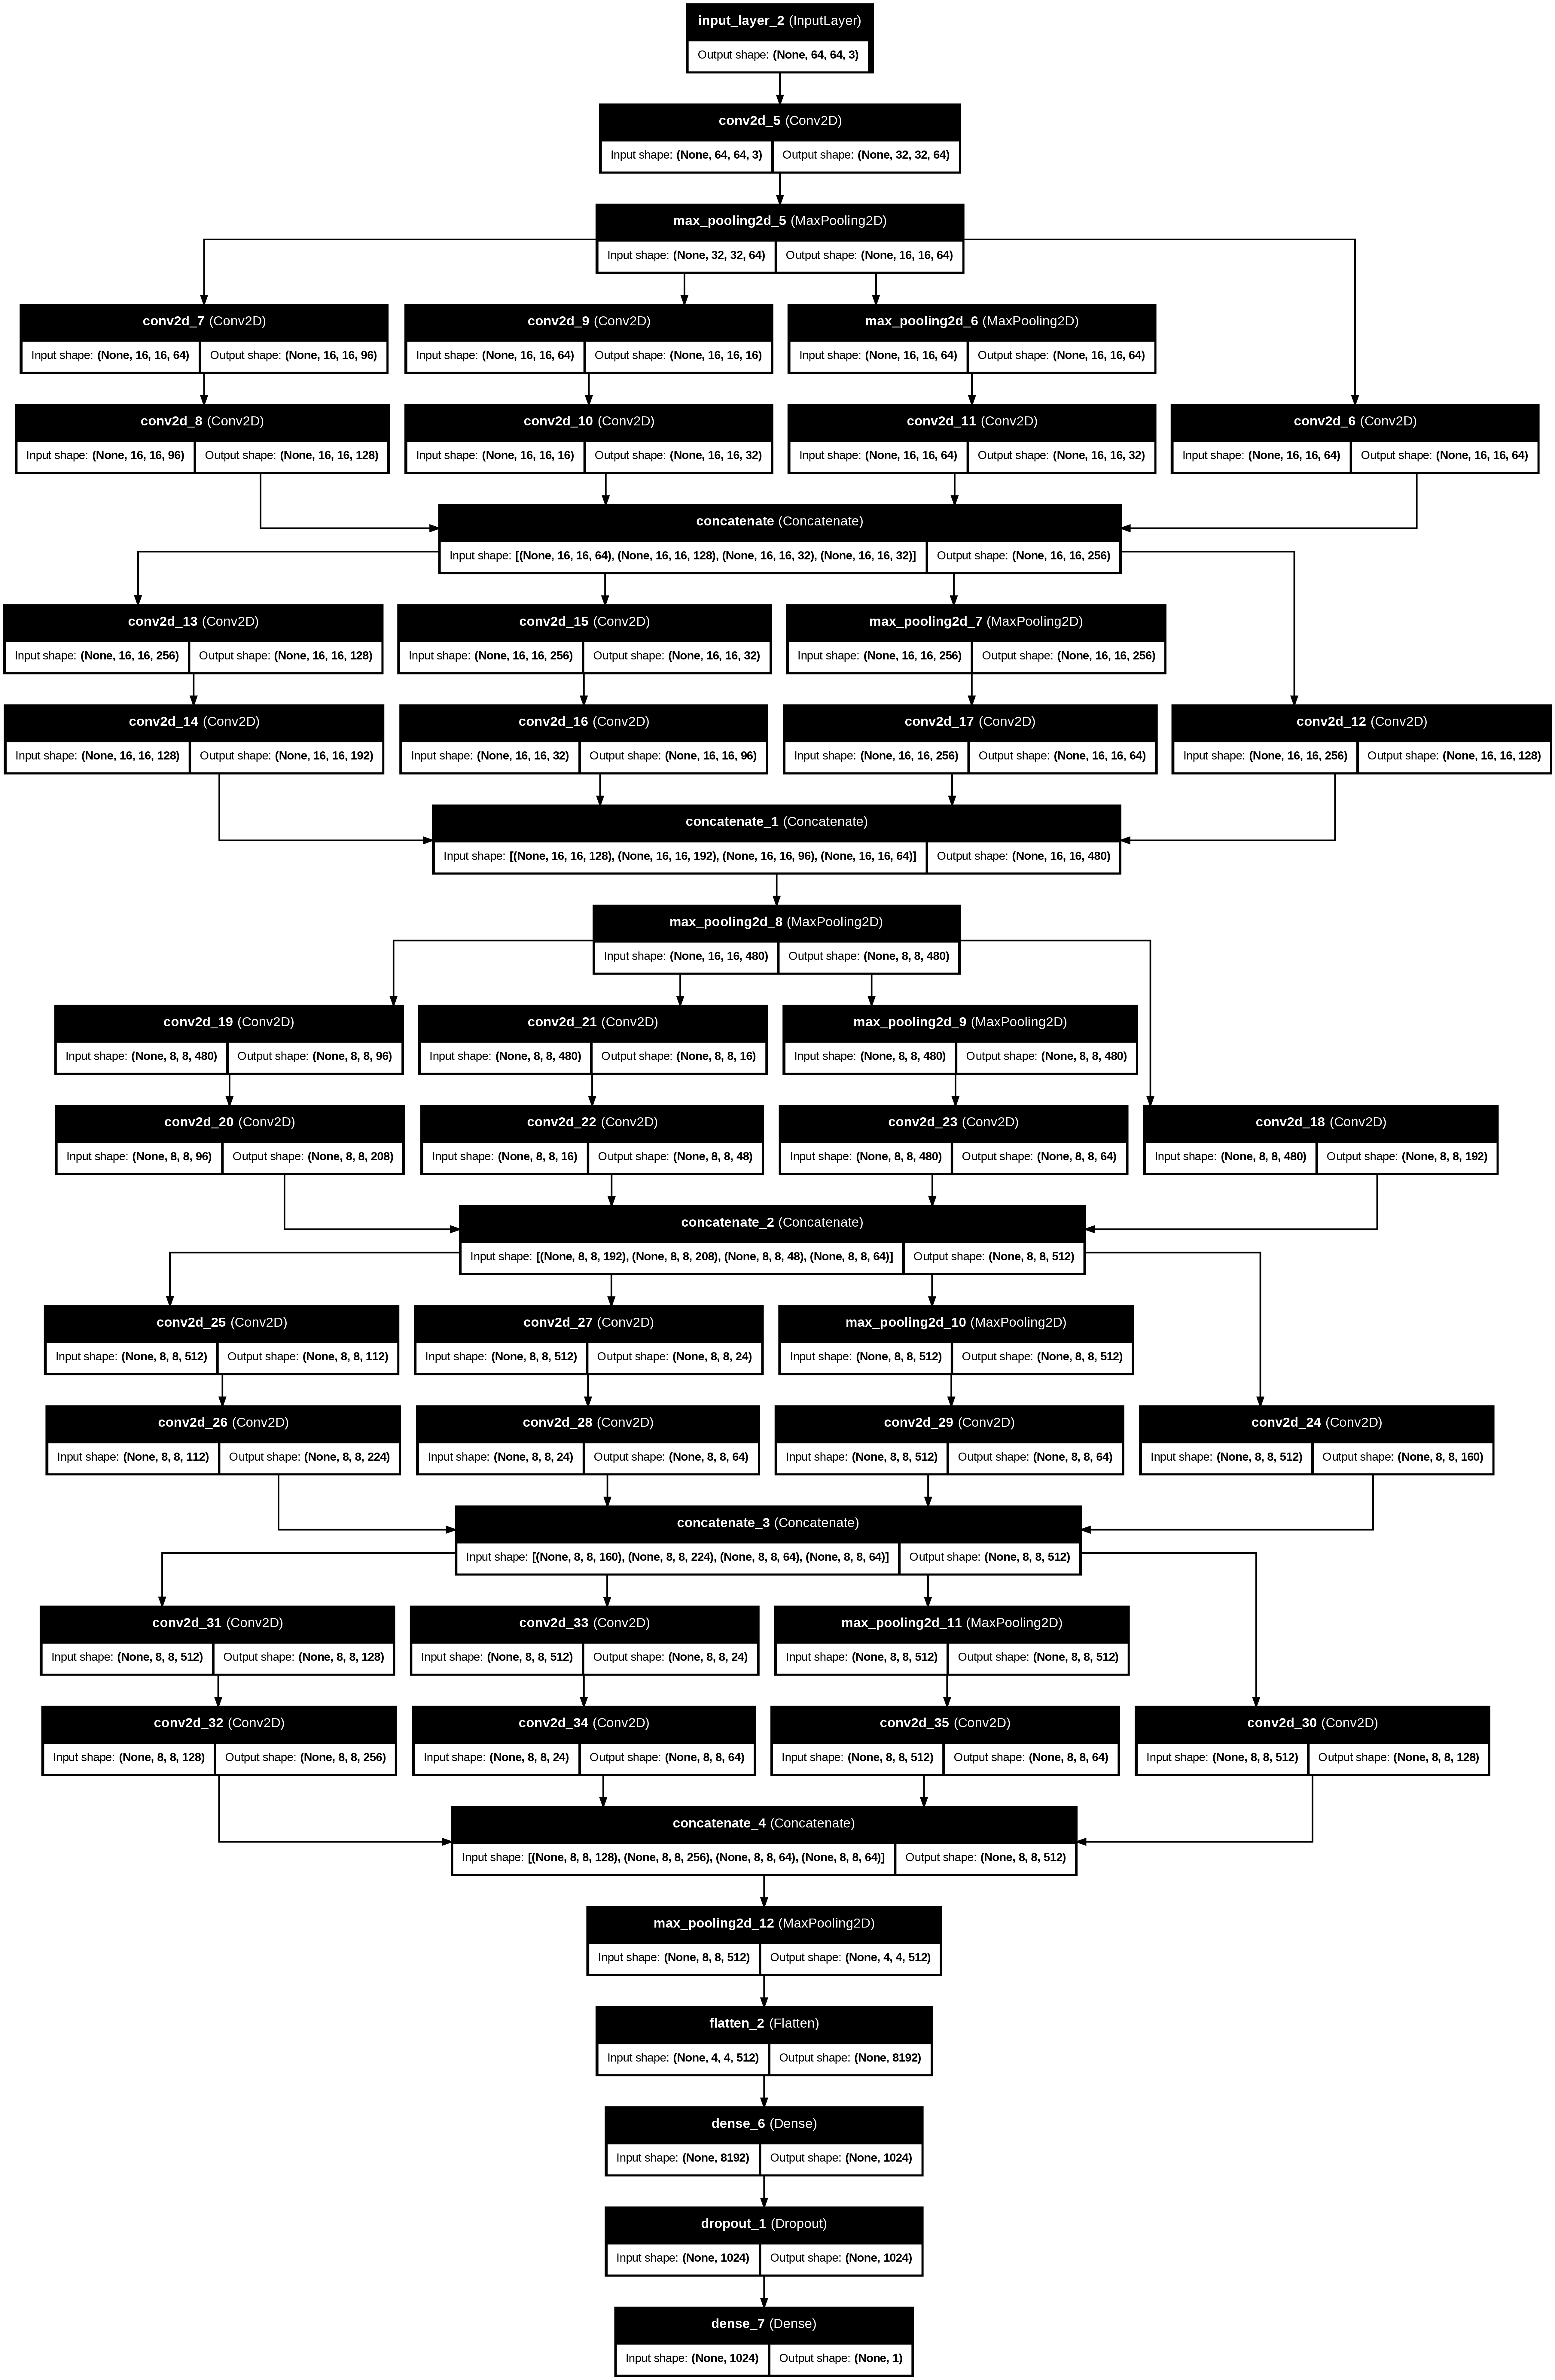

In [13]:
from tensorflow.keras.utils import plot_model

# Print model summary
googlenet.summary()

# Save and display model architecture
plot_model(googlenet, to_file='googlenet_model.png', show_shapes=True, show_layer_names=True)


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Dropout, Flatten, Dense

# Constants
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELS = 3

# Function to create the UNet model
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)

    # Downsampling
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.5)(c4)

    # Upsampling
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)

    # Flatten and Dense layer for single output
    flatten = Flatten()(c7)
    outputs = Dense(1, activation='linear')(flatten)

    model = Model(inputs, outputs)
    return model

# Create and compile the UNet model
unet = unet_model()
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

print("UNet Model Created.")


UNet Model Created.


In [15]:
history_unet = unet.fit(X_train, Y_train, epochs=15, batch_size=32, validation_split=0.2)
unet.save('unet_heart_rate_model.keras')

Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - loss: 11.3583 - mae: 2.6805 - val_loss: 1.0095 - val_mae: 0.7864
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - loss: 1.7422 - mae: 1.0492 - val_loss: 1.0057 - val_mae: 0.7840
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 1.9376 - mae: 1.1303 - val_loss: 1.0660 - val_mae: 0.8273
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 2.0786 - mae: 1.1754 - val_loss: 1.0706 - val_mae: 0.8308
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - loss: 1.4414 - mae: 0.9638 - val_loss: 1.0901 - val_mae: 0.8456
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - loss: 1.7622 - mae: 1.0454 - val_loss: 1.1207 - val_mae: 0.8648
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - loss: 1.4490 - mae: 0.9485 - val_loss: 1.1727 - val_mae: 0.8986
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - loss: 1.6563 - mae: 1.0083 - val_loss: 1.2580 - val_mae: 0.9453
Epoch 9/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - loss: 1.31

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 64, 64,    │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ dropout_2[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 16, 16,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 16, 16,    │    442,496 │ concatenate_5[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,306,597 (12.61 MB)

 Trainable params: 1,101,729 (4.20 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 2,203,460 (8.41 MB)

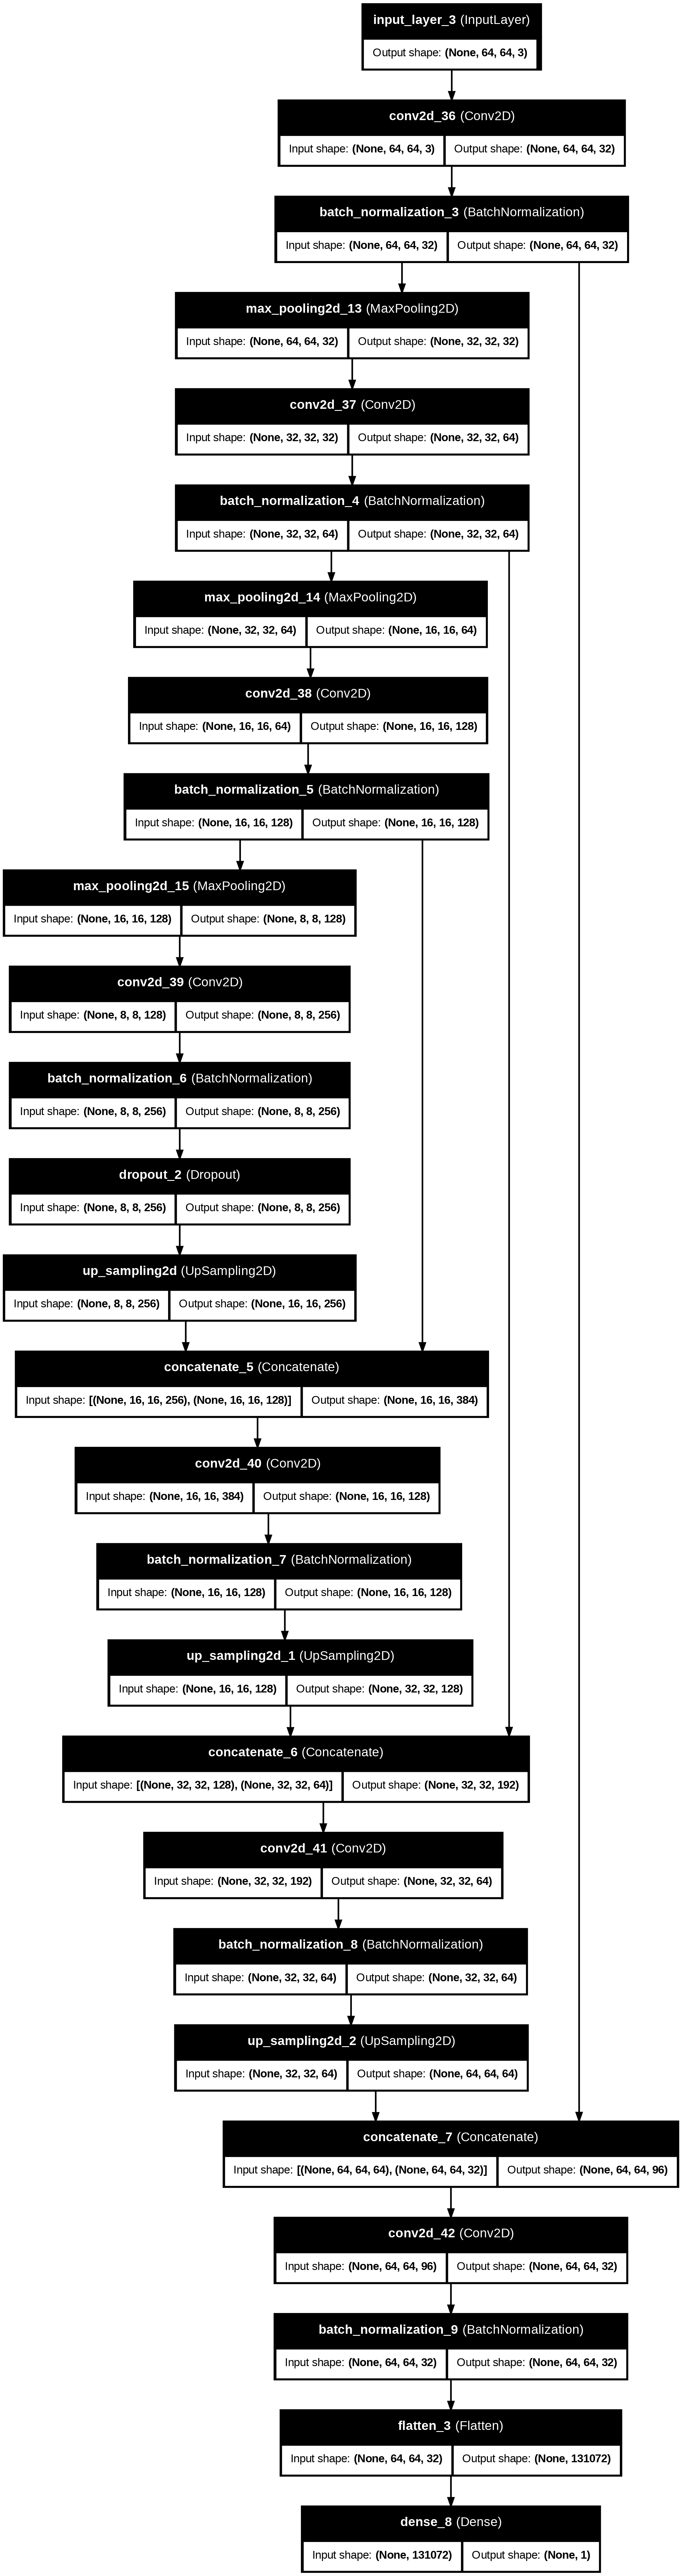

In [16]:
from tensorflow.keras.utils import plot_model

# Print model summary
unet.summary()

# Save and display model architecture
plot_model(unet, to_file='unet_model.png', show_shapes=True, show_layer_names=True)


In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate model on test set
test_loss, test_mae = unet.evaluate(X_test, Y_test)

# Predict on test set
Y_pred = unet.predict(X_test)

# Compute MSE
mse = mean_squared_error(Y_test, Y_pred)

# Compute RMSE
rmse = np.sqrt(mse)

# Compute MAE
mae = mean_absolute_error(Y_test, Y_pred)

# Print results
print(f"Test Loss (MSE from model): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 712ms/step - loss: 1.1843 - mae: 0.8495
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 602ms/step
Test Loss (MSE from model): 1.2635
Test MAE: 0.8794
Mean Squared Error (MSE): 1.2635
Root Mean Squared Error (RMSE): 1.1241
Mean Absolute Error (MAE): 0.8794


In [18]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average, Input
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load models
lenet = load_model('lenet_hr_model.keras')
cnn = load_model('cnn_hr_model.keras')
unet = load_model('unet_heart_rate_model.keras')
googlenet = load_model('googlenet_hr_model.keras')

# Define input
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Get outputs from each model
lenet_output = lenet(inputs)
cnn_output = cnn(inputs)
unet_output = unet(inputs)
googlenet_output = googlenet(inputs)

# Ensemble by averaging the outputs
ensemble_output = Average()([lenet_output, cnn_output, unet_output, googlenet_output])

# Create ensemble model
ensemble_model = Model(inputs, ensemble_output)
ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='mse', metrics=['mae'])

# Save ensemble model
ensemble_model.save('ensemble_hr_model.keras')


In [19]:
# Load the ensemble model
ensemble_model = load_model('ensemble_hr_model.keras')

# Evaluate on test set
test_loss, test_mae = ensemble_model.evaluate(X_test, Y_test)

# Predict on test set
Y_pred = ensemble_model.predict(X_test)

# Compute MSE
mse = mean_squared_error(Y_test, Y_pred)

# Compute RMSE
rmse = np.sqrt(mse)

# Compute MAE
mae = mean_absolute_error(Y_test, Y_pred)

# Print results
print(f"Test Loss (MSE from model): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 250 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.0015 - mae: 0.7873
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
Test Loss (MSE from model): 1.0713
Test MAE: 0.8154
Mean Squared Error (MSE): 1.0713
Root Mean Squared Error (RMSE): 1.0350
Mean Absolute Error (MAE): 0.8154


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 1)         │    389,561 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 1)         │  1,307,073 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 1)         │  1,103,137 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 1)         │ 10,261,377 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ sequential[0][0], │
│                     │                   │            │ functional_3[0][… │
│                     │                   │            │ functional_2[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,179,734 (149.46 MB)

 Trainable params: 13,059,292 (49.82 MB)

 Non-trainable params: 1,856 (7.25 KB)

 Optimizer params: 26,118,586 (99.63 MB)

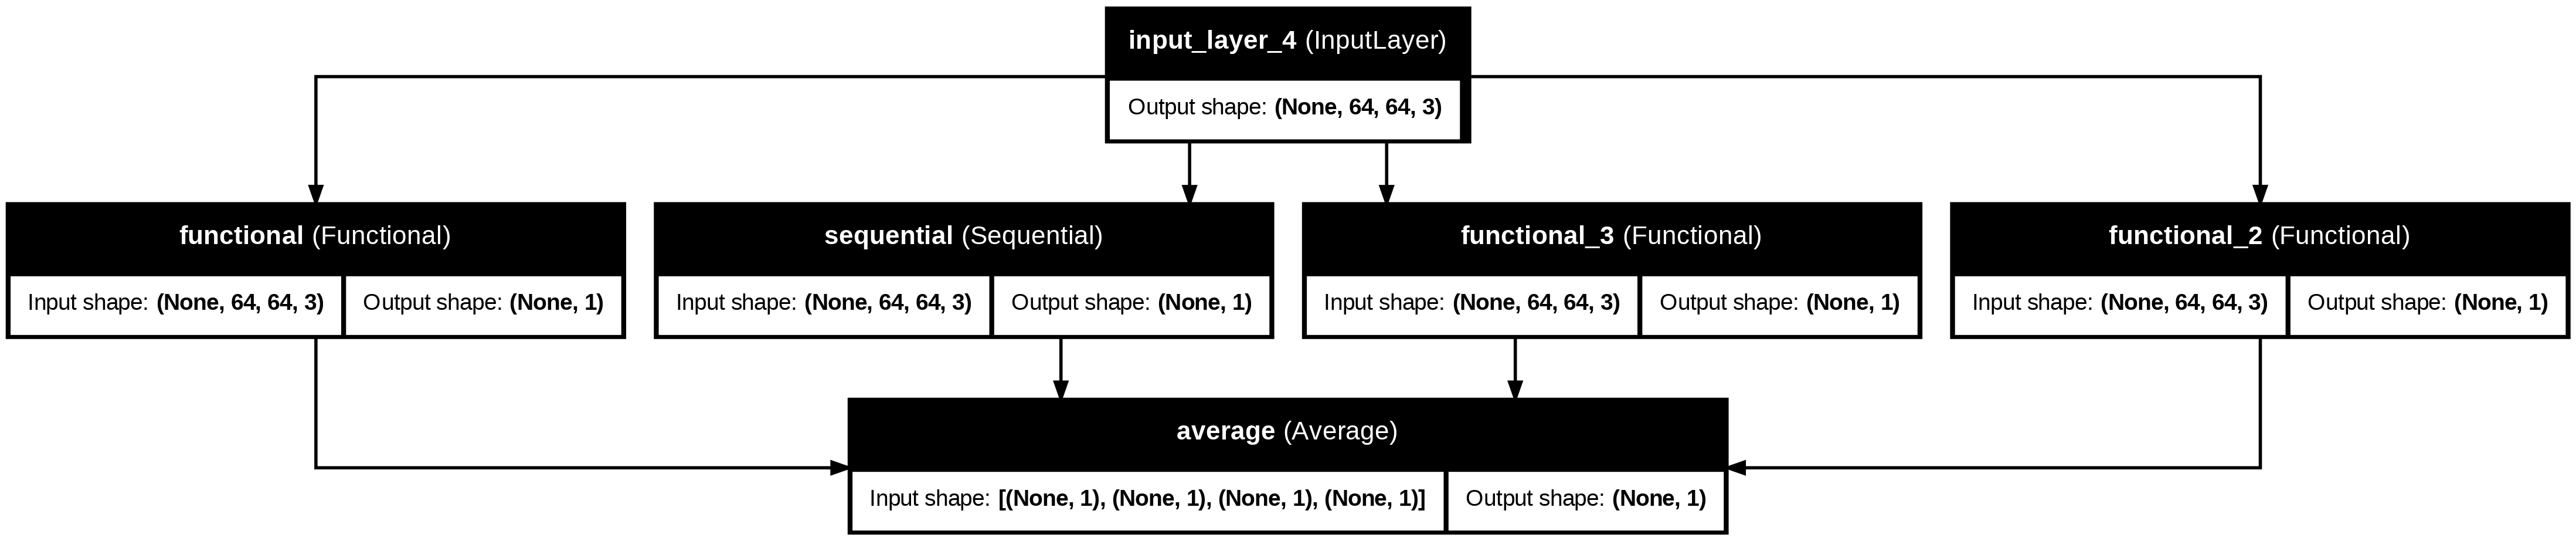

In [20]:
from tensorflow.keras.utils import plot_model

# Print model summary
ensemble_model.summary()

# Save and display model architecture
plot_model(ensemble_model, to_file='ensemble_model.png', show_shapes=True, show_layer_names=True)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 695ms/step


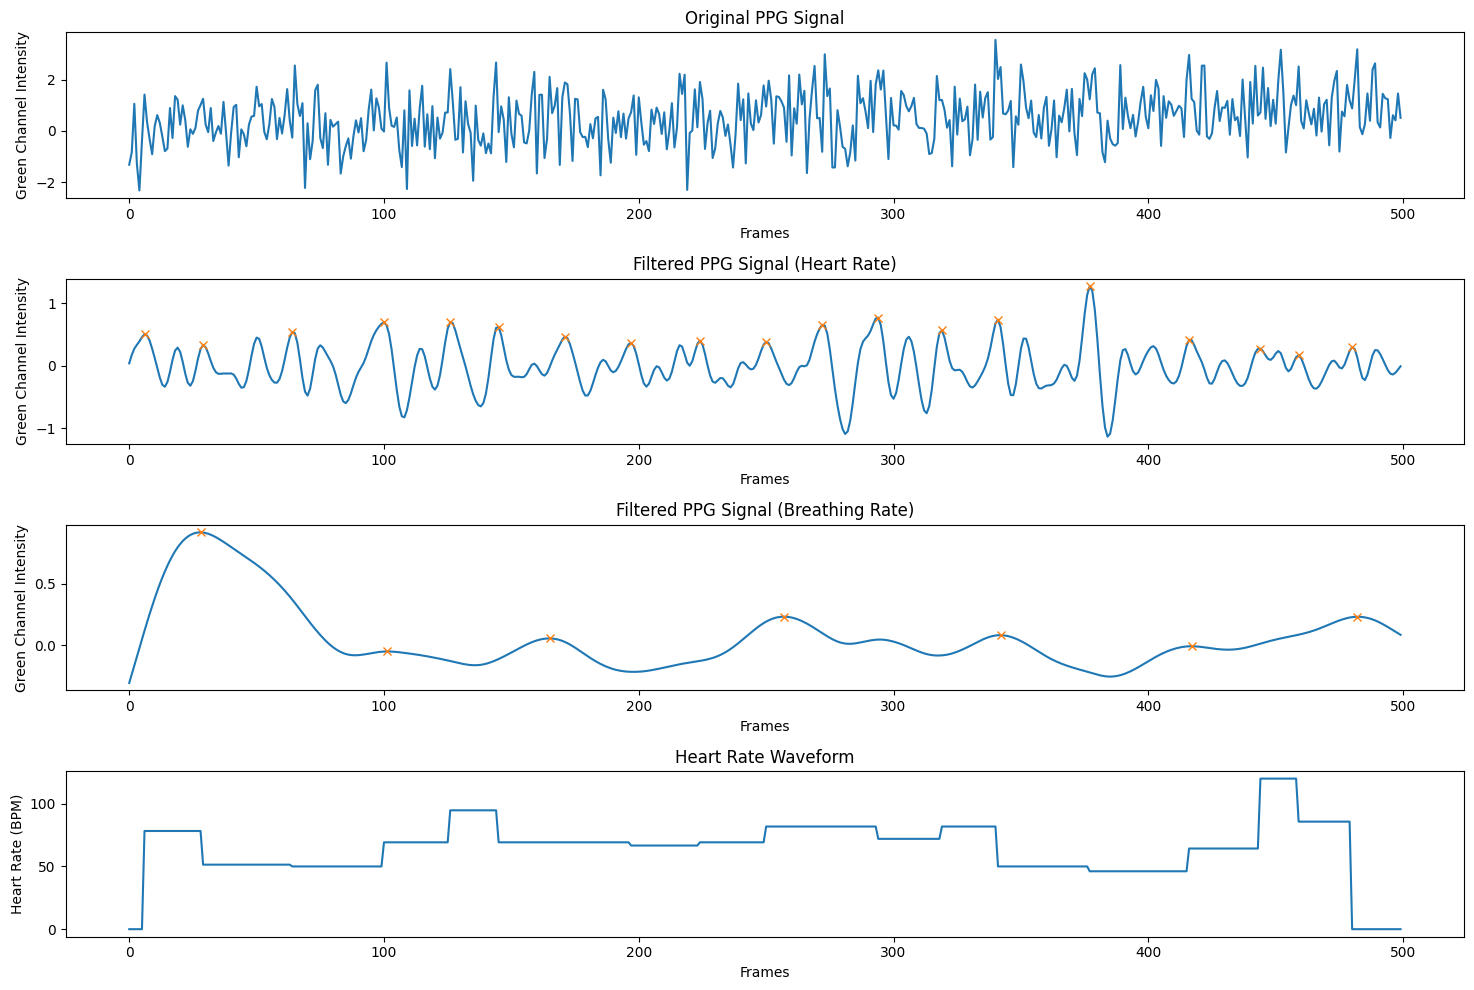

Estimated Heart Rate: 68.35 BPM
Estimated Breathing Rate: 23.79 BPM
Ground Truth Heart Rate: 79.33 BPM
Accuracy: 86.16%


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from sklearn.metrics import mean_absolute_error

# Constants
IMG_WIDTH, IMG_HEIGHT = 64, 64  # Match model expected input size
NUM_FRAMES = 100  # Max frames to extract
FS = 30  # Sampling frequency (FPS)

# Function to extract frames from video
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while len(frames) < NUM_FRAMES:
        ret, frame = cap.read()
        if not ret:
            break  # Stop if video ends

        frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))  # Resize
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        print("Error: No frames extracted.")
        return None

    frames = np.array(frames).astype('float32') / 255.0  # Normalize
    return frames

# Function to apply a Butterworth bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Extract frames from uploaded video
video_path = "/content/drive/MyDrive/hr_ds/subject3/vid.avi"
live_frames = extract_frames(video_path)

if live_frames is not None:
    live_frames = np.reshape(live_frames, (-1, 64, 64, 3))

    # Predict HR using ensemble model
    predicted_hr = ensemble_model.predict(live_frames)

    # Process PPG signal (example using synthetic data)
    ppg_signal = np.random.randn(500) + np.linspace(0, 1, 500)

    # Apply filters for heart rate and breathing rate
    heart_rate_signal = butter_bandpass_filter(ppg_signal, 0.8, 3.0, FS, order=2)
    breathing_rate_signal = butter_bandpass_filter(ppg_signal, 0.1, 0.5, FS, order=2)

    # Calculate heart rate
    peaks, _ = find_peaks(heart_rate_signal, distance=FS/2)
    peak_intervals = np.diff(peaks) / FS
    estimated_heart_rate = 60 / np.mean(peak_intervals)

    # Calculate breathing rate
    breathing_peaks, _ = find_peaks(breathing_rate_signal, distance=FS*2)
    breathing_intervals = np.diff(breathing_peaks) / FS
    estimated_breathing_rate = 60 / np.mean(breathing_intervals)

    # Ground truth heart rate (example value, replace with actual ground truth)
    ground_truth_heart_rate = 79.33

    # Calculate accuracy
    accuracy = (1 - mean_absolute_error([ground_truth_heart_rate], [estimated_heart_rate]) / ground_truth_heart_rate) * 100

    # Plot the results
    plt.figure(figsize=(15, 10))

    plt.subplot(4, 1, 1)
    plt.plot(ppg_signal)
    plt.title('Original PPG Signal')
    plt.xlabel('Frames')
    plt.ylabel('Green Channel Intensity')

    plt.subplot(4, 1, 2)
    plt.plot(heart_rate_signal)
    plt.plot(peaks, heart_rate_signal[peaks], "x")
    plt.title('Filtered PPG Signal (Heart Rate)')
    plt.xlabel('Frames')
    plt.ylabel('Green Channel Intensity')

    plt.subplot(4, 1, 3)
    plt.plot(breathing_rate_signal)
    plt.plot(breathing_peaks, breathing_rate_signal[breathing_peaks], "x")
    plt.title('Filtered PPG Signal (Breathing Rate)')
    plt.xlabel('Frames')
    plt.ylabel('Green Channel Intensity')

    plt.subplot(4, 1, 4)
    heart_rate_waveform = np.zeros_like(ppg_signal)
    for i in range(len(peaks)-1):
        heart_rate_waveform[peaks[i]:peaks[i+1]] = 60 / ((peaks[i+1] - peaks[i]) / FS)
    plt.plot(heart_rate_waveform)
    plt.title('Heart Rate Waveform')
    plt.xlabel('Frames')
    plt.ylabel('Heart Rate (BPM)')

    plt.tight_layout()
    plt.show()

    print(f"Estimated Heart Rate: {estimated_heart_rate:.2f} BPM")
    print(f"Estimated Breathing Rate: {estimated_breathing_rate:.2f} BPM")
    print(f"Ground Truth Heart Rate: {ground_truth_heart_rate:.2f} BPM")
    print(f"Accuracy: {accuracy:.2f}%")
else:
    print("Skipping prediction due to frame extraction error.")


In [22]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.0 MB/s eta 0:00:00


In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gradio as gr
from scipy.signal import find_peaks, butter, filtfilt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

# Load trained ensemble model
ensemble_model = load_model('ensemble_hr_model.keras')

# Constants
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 64, 64, 3  # Match model expected input size
FS = 30  # Sampling frequency (Frames per second)
NUM_FRAMES = 100  # Number of frames for processing

# Function to apply a Butterworth bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Function to process video and predict heart rate
def process_video(video_file):
    cap = cv2.VideoCapture(video_file)
    frames = []

    while len(frames) < NUM_FRAMES:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        return "Error: No frames extracted."

    frames = np.array(frames).astype('float32') / 255.0  # Normalize
    frames = np.reshape(frames, (-1, IMG_HEIGHT, IMG_WIDTH, 3))

    # Predict Heart Rate using the ensemble model
    predicted_hr = ensemble_model.predict(frames)

    # Generate synthetic PPG signal for demonstration
    ppg_signal = np.sin(np.linspace(0, 10, 500)) + np.random.randn(500) * 0.1

    # Apply filters
    heart_rate_signal = butter_bandpass_filter(ppg_signal, 0.8, 3.0, FS, order=2)
    breathing_rate_signal = butter_bandpass_filter(ppg_signal, 0.1, 0.5, FS, order=2)

    # Detect heart rate peaks
    peaks, _ = find_peaks(heart_rate_signal, distance=FS/2)
    peak_intervals = np.diff(peaks) / FS
    estimated_heart_rate = 60 / np.mean(peak_intervals)

    # Detect breathing rate peaks
    breathing_peaks, _ = find_peaks(breathing_rate_signal, distance=FS*2)
    breathing_intervals = np.diff(breathing_peaks) / FS
    estimated_breathing_rate = 60 / np.mean(breathing_intervals)

    # Example Ground Truth (Replace with actual)
    ground_truth_heart_rate = 79.33
    accuracy = (1 - mean_absolute_error([ground_truth_heart_rate], [estimated_heart_rate]) / ground_truth_heart_rate) * 100

    # Plot results
    fig, axes = plt.subplots(4, 1, figsize=(10, 12))

    axes[0].plot(ppg_signal)
    axes[0].set_title("Original PPG Signal")

    axes[1].plot(heart_rate_signal)
    axes[1].plot(peaks, heart_rate_signal[peaks], "x", color="red")
    axes[1].set_title("Filtered Heart Rate Signal")

    axes[2].plot(breathing_rate_signal)
    axes[2].plot(breathing_peaks, breathing_rate_signal[breathing_peaks], "x", color="red")
    axes[2].set_title("Filtered Breathing Rate Signal")

    heart_rate_waveform = np.zeros_like(ppg_signal)
    for i in range(len(peaks)-1):
        heart_rate_waveform[peaks[i]:peaks[i+1]] = 60 / ((peaks[i+1] - peaks[i]) / FS)
    axes[3].plot(heart_rate_waveform)
    axes[3].set_title("Heart Rate Waveform")

    plt.tight_layout()

    return f"Estimated HR: {estimated_heart_rate:.2f} BPM\nAccuracy: {accuracy:.2f}%", fig

# Gradio UI for Live Processing
iface = gr.Interface(
    fn=process_video,
    inputs=gr.Video(label="Upload Video"),
    outputs=[gr.Textbox(label="Heart Rate & Accuracy"), gr.Plot(label="PPG Graphs")],
    title="Contactless Heart Rate Monitoring",
    description="Upload a short video, and the system will estimate the heart rate using deep learning and signal processing.",
)

iface.launch()


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 250 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://299efce6ab8d744539.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
